<a href="https://colab.research.google.com/github/weasel-codes/email-spam/blob/main/Unsupervised_feature_learning_for_spam_email_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised feature learning for spam email filtering

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt
import os
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import gensim, warnings
import gensim.downloader as api

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset Import

## Email

### Dataset Insight

In [51]:
df = pd.read_csv("/content/drive/MyDrive/ML/email-filtering/eron_email_96.csv")
print("email dataset shape : ", df.shape)
df.head()

email dataset shape :  (37308, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [52]:
print(df.loc[0]['message'])
message = df.loc[2]['message']
e = email.message_from_string(message)
print("######## \nEmail in json format resembling csv and column wise data : \n" , e.items())
print("printing al the keys in message : \n" , e.keys())

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 
######## 
Email in json format resembling csv and column wise data : 
 [('Message-ID', '<24216240.1075855687451.JavaMail.evans@thyme>'), ('Date', 'Wed, 18 Oct 2000 03:00:00 -0700 (PDT)'), ('From', 'phillip.allen@enron.com'), ('To', 'leah.arsdall@enron.com'), ('Subject', 'Re: test'), ('Mime-Version', '1.0'), ('Content-Type', 'text/plain; charset=us-ascii'), ('Content-Transfer-Encoding', '7bit'), ('X-From', 'Phillip K Allen'), ('X-To', 'Leah Van Arsdall'), ('X-cc', ''), ('X-bcc', ''), ('X-Folder', "\\Phi

### Generating required columns

In [53]:
# fetching only required columns
def body(d):
    message = df['message']
    column = []
    frm = []
    sub = []
    emp = []

    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
        frm.append(e.get('From'))
        sub.append(e.get('Subject'))

    f = df['file']
    for string in f:
      emp.append(string.split("/")[0])

    return column, frm, sub, emp

df['body'], df['from'], df['subject'], df['emp'] = body(df)
df.head(3)

,file,message,body,from,subject,emp
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p


### Deleted not required columns

In [54]:
df.head()

,file,message,body,from,subject,emp
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",phillip.allen@enron.com,,allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,Re: Hello,allen-p


In [55]:
df.drop(labels = ['file','message'], axis=1, inplace=True)
df.head()

,body,from,subject,emp
0,Here is our forecast\n\n,phillip.allen@enron.com,,allen-p
1,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
2,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p
3,"Randy,\n\n Can you send me a schedule of the s...",phillip.allen@enron.com,,allen-p
4,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,Re: Hello,allen-p


### Replace empty missing values in subject with np.nan

In [56]:
df.isnull().sum(), df.shape

(body       0
 from       0
 subject    0
 emp        0
 dtype: int64, (37308, 4))

In [57]:
def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan) 
        else:
            column.append(val)
    return column
df['subject'] = replace_empty_with_nan(df['subject'])

### Check for isnull

In [58]:
# drop missing value rows
df.dropna(axis=0, inplace=True)
df.isnull().sum(), df.shape

(body       0
 from       0
 subject    0
 emp        0
 dtype: int64, (34553, 4))

### Top 10 email sender

SELECT

In [62]:
top_10 = pd.DataFrame(df['emp'].value_counts()[:10])
top_10.reset_index(inplace=True)
top_10.columns = ["emp", "count"]
top_10

,emp,count
0,beck-s,11693
1,bass-e,7229
2,arnold-j,3896
3,blair-l,3369
4,baughman-d,2700
5,allen-p,2174
6,badeer-r,868
7,brawner-s,760
8,benson-r,755
9,arora-h,634


VISUALIZE

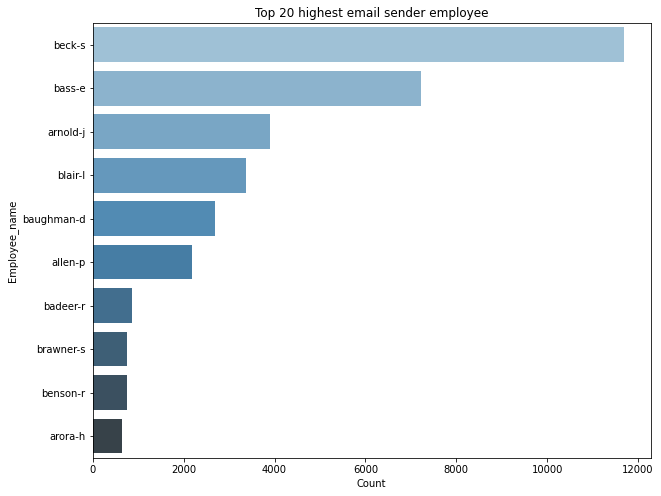

In [66]:
plt.figure(figsize=(10,8))
sns.barplot(y="emp", x="count", data=top_10, palette="Blues_d")
plt.title("Top 20 highest email sender employee")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()



### Generating CSV

In [67]:
# save the data
df.to_csv("/content/drive/MyDrive/ML/email-filtering/enron_email_96_cleaned_data.csv", index=False)

## IMDB Review

In [152]:
arry = []
file_name = []
# iterate through all file 
for file in os.listdir("/content/drive/MyDrive/ML/email-filtering/imdb_unsup"): 
    # Check whether file is in text format or not 
    if file.endswith(".txt"): 
        file_path = f"/content/drive/MyDrive/ML/email-filtering/imdb_unsup/{file}"
        print("...Reading file : ", file_path)
        # call read text file function 
        # read_text_file(file_path) 
        f = open(file_path, "r")
        x = ""
        for w in f:
          x = x + " " + w
        arry.append(x)
        file_name.append(f.name)
        
imdb = [arry, file_name]

...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/105_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/217_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/36_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/439_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/436_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/206_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/9_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/1_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/349_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/272_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/204_0.txt
...Reading file :  /content/drive/MyDrive/ML/email-filtering/imdb_unsup/555_0.txt
...Reading file :  /c

In [153]:
df = pd.DataFrame()
df['review'] = arry
df['path'] = file_name
df.describe

<bound method NDFrame.describe of                                                  review                                               path
0      Rob Reiner is hilarious. I haven't seen the m...  /content/drive/MyDrive/ML/email-filtering/imdb...
1      Ringu 0 fills in a few of the blanks in the R...  /content/drive/MyDrive/ML/email-filtering/imdb...
2      I saw this on cable last night, just 2 days a...  /content/drive/MyDrive/ML/email-filtering/imdb...
3      I saw this for about the third time last nigh...  /content/drive/MyDrive/ML/email-filtering/imdb...
4      Magnificent Warriors is an enjoyable and ente...  /content/drive/MyDrive/ML/email-filtering/imdb...
...                                                 ...                                                ...
996    Omg! I love days, it is so awesome. I have be...  /content/drive/MyDrive/ML/email-filtering/imdb...
997    I've seen the movie at the Malaga Festival, S...  /content/drive/MyDrive/ML/email-filtering/imdb...
998

### Generating CSV

In [154]:
# save the data
df.to_csv("/content/drive/MyDrive/ML/email-filtering/imdb_data.csv", index=False)

## Further Preprocessing of Enron

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ML/email-filtering/enron_email_96_cleaned_data.csv")
df.head()

,body,from,subject,emp
0,Traveling to have a business meeting takes the...,phillip.allen@enron.com,Re:,allen-p
1,test successful. way to go!!!,phillip.allen@enron.com,Re: test,allen-p
2,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,Re: Hello,allen-p
3,"Greg,\n\n How about either next Tuesday or Thu...",phillip.allen@enron.com,Re: Hello,allen-p
4,any morning between 10 and 11:30,phillip.allen@enron.com,Re: PRC review - phone calls,allen-p


In [4]:
df.isnull().sum(), df.shape

(body       0
 from       0
 subject    0
 emp        0
 dtype: int64, (34553, 4))

In [5]:
text = df['body'][0]

In [7]:
def createTokenOfDoc(text) :# split into tokens by white space
  tokens = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

def addDocToVocab() :
  for i in range(df.shape[0]) :
    msg = df['body'][i]

In [8]:
data = [d for d in df['body']]

In [9]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      temp = createTokenOfDoc(list_of_words)
      yield gensim.models.doc2vec.TaggedDocument(temp, [i])

In [14]:
training_data = list(tagged_document(data))

In [15]:
print(training_data[:1])

[TaggedDocument(words=['Traveling', 'business', 'meeting', 'takes', 'fun', 'trip', 'Especially', 'prepare', 'presentation', 'would', 'suggest', 'holding', 'business', 'plan', 'meetings', 'take', 'trip', 'without', 'formal', 'business', 'meetings', 'would', 'even', 'try', 'get', 'honest', 'opinions', 'whether', 'trip', 'even', 'desired', 'necessary', 'As', 'far', 'business', 'meetings', 'think', 'would', 'productive', 'try', 'stimulate', 'discussions', 'across', 'different', 'groups', 'working', 'Too', 'often', 'presenter', 'speaks', 'others', 'quiet', 'waiting', 'turn', 'The', 'meetings', 'might', 'better', 'held', 'round', 'table', 'discussion', 'format', 'My', 'suggestion', 'go', 'Austin', 'Play', 'golf', 'rent', 'ski', 'boat', 'jet', 'skis', 'Flying', 'somewhere', 'takes', 'much', 'time'], tags=[0])]


In [16]:
model_dbow = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30, dm=0)
model_pvdm = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30, dm=1)

In [17]:
model_pvdm.build_vocab(training_data)
model_dbow.build_vocab(training_data)

In [18]:
model_pvdm.train(training_data, total_examples=model_pvdm.corpus_count, epochs=model_pvdm.epochs)
model_dbow.train(training_data, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [19]:
print(model_pvdm.infer_vector(['violent', 'means', 'to', 'destroy', 'the','organization']))

[ 0.21906167 -0.04755198 -0.18405055  0.29257524 -0.12428429 -0.10712081
  0.09656919  0.1415669   0.14353591 -0.06794018 -0.18306084 -0.04052676
 -0.22831178 -0.01623837  0.08603929 -0.22757185 -0.32085246  0.32467893
  0.09781467 -0.01549011 -0.18330312 -0.04584618 -0.30970886 -0.16448371
 -0.33871233  0.06283942  0.14584975  0.13372241  0.00765933  0.2042862
  0.0255267   0.17516422  0.06241405 -0.03990404  0.33692127 -0.08878323
  0.22658172 -0.07366302 -0.16770764 -0.09443679]


In [20]:
print(model_dbow.infer_vector(['violent', 'means', 'to', 'destroy', 'the','organization']))

[ 0.3584102  -0.5408498   0.2109375   0.07119334  0.20896086  0.11981548
 -0.32668322 -0.00626258  0.27901796 -0.02273053  0.4481902   0.07652568
  0.39902133  0.00837954 -0.2583868   0.5023024   0.27607074 -0.19447395
 -0.08043459  0.16914839 -0.44276494 -0.39575014  0.2549558  -0.30415788
  0.11266185  0.06322607 -0.0285122  -0.01912311 -0.14969748  0.12108255
 -0.20452592 -0.22368553  0.28236237  0.11151958  0.01962592 -0.15626468
  0.1912773   0.5332651  -0.12244439  0.11756217]


In [21]:
model_pvdm.most_similar("violent")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('curiously', 0.7227596044540405),
 ('inly', 0.7137914299964905),
 ('Nazi', 0.669225811958313),
 ('combat', 0.653717041015625),
 ('gibberish', 0.6502127647399902),
 ('detained', 0.6458158493041992),
 ('bashed', 0.640113115310669),
 ('strolling', 0.6398036479949951),
 ('tears', 0.637702465057373),
 ('certa', 0.6376535892486572)]

In [22]:
model_dbow.most_similar("violent")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('silicon', 0.6657581329345703),
 ('BTUs', 0.5954455137252808),
 ('mailtojessicanburkehotmailcom', 0.5918024778366089),
 ('KilchristNAEnronEnron', 0.582676887512207),
 ('Tunku', 0.5789833068847656),
 ('Cogan', 0.5672112703323364),
 ('hereby', 0.5669563412666321),
 ('End', 0.5601180195808411),
 ('Investigation', 0.55833899974823),
 ('whack', 0.5581566691398621)]

In [25]:
model_dbow.save_word2vec_format( fname="/content/drive/MyDrive/ML/email-filtering/model_dbow")

In [26]:
model_pvdm.save_word2vec_format( fname="/content/drive/MyDrive/ML/email-filtering/model_pvdm")